In [ ]:
# default_exp surfaces

In [ ]:
#hide_input
from pivotpy.utils import nav_links 
nav_links(4)

<style>a{text-decoration: none !important;color:lightkblue;font-weight:bold;}
                a:focus,a:active,a:hover{color:hotpink !important;}</style>
> [&nbsp;`▶` Index&nbsp;](https://massgh.github.io/pivotpy/)  
> [&nbsp;`▶` Example&nbsp;](https://massgh.github.io/pivotpy/Example)  
> [&nbsp;`▶` StaticPlots&nbsp;](https://massgh.github.io/pivotpy/StaticPlots)  
> [&nbsp;`▶` InteractivePlots&nbsp;](https://massgh.github.io/pivotpy/InteractivePlots)  
> [&nbsp;`▶` SpinProjectedSurfaces●&nbsp;](https://massgh.github.io/pivotpy/SpinProjectedSurfaces)  
> [&nbsp;`▶` StructureIO&nbsp;](https://massgh.github.io/pivotpy/StructureIO)  
> [&nbsp;`▶` Widgets&nbsp;](https://massgh.github.io/pivotpy/Widgets)  
> [&nbsp;`▶` MainAPI&nbsp;](https://massgh.github.io/pivotpy/MainAPI)  


# Fermi Surfaces and Spin Texture
This module plots 2D and 3D fermi surfaces and spin textures.

In [ ]:
#export
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
# Inside packages import to work both with package and jupyter notebook.
try:
    from pivotpy import parser as vp
    from pivotpy import api, serializer, splots
    from pivotpy.splots import _validate_input
except:
    import pivotpy.parser as vp
    import pivotpy.api as api
    import pivotpy.serializer as serializer
    import pivotpy.splots as splots
    import pivotpy.splots._validate_input as _validate_input

In [ ]:
#export
def _collect_spin_data(exported_spin_data, bands = [0], elements = [[0],], orbs = [[0],], scale_data = False):
    if not isinstance(bands,(list,tuple)):
        raise TypeError('`bands` must be list/tuple of integer.')
    elements, orbs, _ = _validate_input(elements,orbs,[str(i) for i,o in enumerate(orbs)],sys_info = exported_spin_data.sys_info, rgb = False)

    def per_band_data(band):
        kpoints = exported_spin_data.kpoints
        evals = {k: v[:,band] for k,v in exported_spin_data.evals.items() if k in 'eud'}
        spins = {k: v[:,:,band,:] for k,v in exported_spin_data.spins.items() if k in 'sxyzud'}

        df_dict = {f'k{k}':v for k,v in zip('xyz',kpoints.T)}
        df_dict['band'] = [(band + exported_spin_data.evals.indices[0] + 1) for i in range(len(kpoints))]

        for k,v in evals.items():
            df_dict[k if k=='e' else f'e{k}'] = v.T.flatten() - exported_spin_data.sys_info.fermi

        for i, (e, o) in enumerate(zip(elements,orbs)):
            for k,v in spins.items():
                if k in 'sxyzud':
                    key = k if k == 's' else f's{k}'
                    df_dict[f'{key}_{i}'] = v.take(e,axis=0).take(o,axis=2).sum(axis=2).sum(axis=0).T.flatten()
        
        return df_dict
    
    main_dict = per_band_data(bands[0])
    for b in bands[1:]:
        data = per_band_data(b)
        for k, v in main_dict.items():
            main_dict[k] = [*main_dict[k], *data[k]]
    
    if elements and scale_data == True: # Only scale if projections given
        _max = []
        for k,v in main_dict.items():
            if k.startswith('s'):
                _max.append(np.abs(v).max())

        _max = max(_max)
        for k,v in main_dict.items():
            if k.startswith('s'):
                main_dict[k] = v / (_max if _max != 0 else 1)
    return main_dict

In [ ]:
#export
class SpinDataFrame(pd.DataFrame):
    """Spin data from vasprun.xml is converted to a dataframe.
    - **Parameters**:
        - path: path to `vasprun.xml` or auto picks in current directory.
        - bands: list of band indices [zero based here], In output data frame you will see corresponding band number based on full data.
        - elements: list of elements to plot. inner list contains ions indices. Can leave empty to discard projection data.
        - orbs: list of orbitals to plot. inner list contains orbitals indices. Can leave empty to discard projection data
        - scale_data: if True, spin data is scaled to -1 to 1.
        - skipk: if not None, auto skipped unnecessary k-points.
        - elim: if not None, filtered out unnecessary bands.
        - data: if not None, data is loaded from given data/pickle/json/dict and validated. Many other parameters are ignored when data is given.

    - **Returns**:
        - SpinDataFrame: dataframe with colums as k-points, eigenvalues[with fermi energy subtracted], spin components projected over selected ions and orbtials.

    - **Methods**:
        - sliced: Slice data in a plane orthogonal to given `column` at given `value`.
        - masked: Mask data over a constant value in a given column. Useful for plotting fermi level/surface.
        - splot: plot data in a 2D plot.
        - splot3d: plot data in a 3D plot.
        - join/append/concat/+/+=: Append another SpinDataFrame to this one with same columns and copy metadata.
        - send_metadata: Copy metadata from this to another SpinDataFrame, some methods may not carry over metadata, useful in that case.
        - get_data: Return data as collection of numpy arrays with kpoints already sent to BZ. Use .to_json() to export to json for plotting in other libraries/languages like Mathematica.
        
        All other methods are inherited from pd.DataFrame. If you apply some method that do not pass metadat, then use `send_metadata` to copy metadata to traget SpinDataFrame.
    """
    _metadata = ['_current_attrs','scale_data','sys_info','poscar','projection'] # These are passed after operations to new dataframe.
    def __init__(self, *args, path = None, bands = [0], elements = [[0],], orbs = [[0],], scale_data = False, elim = None, skipk=None, data = None, **kwargs):
        if not (path or args): # It works fine without path given, but it is not recommended.
            path = './vasprun.xml'
        if path or data: # Don't updates args otherwise
            for k in kwargs.keys(): # Do not let pass parameters to kwargs in this case
                raise ValueError(f'SpinDataFrame got unexpected keyword argument {k!r}')
                
            spin_data = None # To avoid access before assignment
            if data:
                spin_data = serializer.SpinData.validated(data)
            elif isinstance(path, str):
                try: # Check if 4 sets of data are there.
                    spin_data = vp.export_spin_data(path, spins = 'sxyz',skipk = skipk, elim = elim)
                except: # If not 4 sets
                    spin_data = vp.export_spin_data(path, spins = 's',skipk = skipk, elim = elim)
            else:
                raise ValueError('Invalid path or data!')
            
            if spin_data:
                out_dict = _collect_spin_data(spin_data, bands = bands, elements = elements, orbs = orbs, scale_data = scale_data)
                super().__init__(out_dict)
                self.scale_data = scale_data
                self.sys_info = spin_data.sys_info
                elements, orbs, _ = _validate_input(elements,orbs,[str(i) for i,o in enumerate(orbs)],sys_info = self.sys_info, rgb = False)
                self.projection = serializer.Dict2Data({f'_{i}': {'ions': e, 'orbs': o} for i,(e,o) in enumerate(zip(elements,orbs))})
                # Path below is used to get kpoints info
                self.poscar = api.POSCAR(path = path, data = spin_data.poscar)
                self._current_attrs = {'cmap':'viridis'} # To store attributes of current plot for use in colorbar.
        
        else: # This part is only for operations on dataframe.
            if len(args) == 1: # This gives hack to load data from a file in current directory.
                if (args[0] is None) or isinstance(args[0],str): # If path is given as positional argument
                    raise ValueError('SpinDataFrame expects no positional argument!')
            super().__init__(*args, **kwargs)
        
    @property
    def _constructor(self):
        "That's main hero of this class. This is called when you apply some method of slice it."
        return SpinDataFrame

    @property
    def fermi(self):
        "Fermi energy based on occupancy. Returns `self.Fermi` if occupancies cannot be resolved."
        return self.sys_info.fermi
    
    @property
    def Fermi(self):
        "Fermi energy given in vasprun.xml."
        return self.sys_info.Fermi
    
    def append(self, other):
        "Append another SpinDataFrame to this one with same columns."
        for k in other.columns:
            if k not in self.columns:
                raise ValueError(f'Column {k} in other is not not in this DataFrame!')
        if len(self.columns) != len(other.columns):
            raise ValueError('Columns are not same!')
        out_df = super().append(other)
        self.send_metadata(out_df)
        return out_df
    
    def join(self,other):
        "Same as self.append"
        return self.append(other)
    
    def concat(self,other):
        "Same as self.append"
        return self.append(other)
    
    def __add__(self, other):
        "Same as self.append"
        return self.append(other)
    
    def get_data(self,shift = 0):
        """Access Data with transformed KPOINTS based on current Brillouin Zone.
        shift is used to shift kpoints before any other operation.
        If You need to have kpoints in primitive/regular BZ, first use .poscar.set_bz() to set that kind of BZ."""
        bands = np.unique(self['band'].to_numpy()).astype(int)
        out_dict = {'SYSTEM': self.sys_info.SYSTEM}
        out_dict['elements'] = self.poscar.data.unique
        out_dict['orbitals'] = self.sys_info.fields
        out_dict['projection'] = self.projection
        out_dict['bz'] = self.poscar.bz._asdict()
        out_dict['bz']['specials'] = self.poscar.bz.specials._asdict()
        
        for band in bands:
            name = f'band_{band}'
            df = self[self['band'] == band].sort_values(by = ['kx','ky','kz'])
            kx, ky, kz = df.poscar.bring_in_bz(df[['kx','ky','kz']].to_numpy(), sys_info = df.sys_info,shift = shift).T
            out_dict[name] = {'kx':kx,'ky':ky,'kz':kz}
        
            for k in df.columns:
                if k not in ('band', *out_dict[name].keys()):
                    out_dict[name][k] = df[k].to_numpy()

        return serializer.Dict2Data(out_dict)
    
    

    def masked(self, column, value, tol = 1e-2, n = None, band = None, method = 'linear'):
        """Mask dataframe with a given value, using a tolerance.
        If n is given, (band should also be given to avoid multivalued interpolation error) data values are interpolated to grid of size (l,m,n) where n is longest side.
        n could be arbirarily large as mask will filter out data outside the tolerance."""
        if n and not isinstance(n,int):
            raise TypeError('`n` must be an integer to be applied to short side of grid.')
        if isinstance(n,int) and not isinstance(band,int):
            raise ValueError('A single `band`(int) from dataframe must be given to mask data.'
            'Interpolation does not give correct results for multiple values over a point (x,y,z).')
        
        column_vals = self[column].to_numpy()
        cmin, cmax = column_vals.min(), column_vals.max()
        if (value < cmin) or (value > cmax):
            raise ValueError('value is outside of column data range!')

        df = self.copy() # To avoid changing original dataframe
        if n and band:
            bands_exist  = np.unique(self.band)
            if band not in bands_exist:
                raise ValueError('Band {} is not in dataframe! Available: {}'.format(band, bands_exist))
            
            _self_ = df[df['band'] == band] # Single band dataframe
            df.drop(df.index, inplace=True)  # only columns names there and metadata
            kxyz = _self_[['kx','ky','kz']].to_numpy()
            lx,*_,hx = _self_['kx'].sort_values(inplace=False)
            ly,*_,hy = _self_['ky'].sort_values(inplace=False)
            lz,*_,hz = _self_['kz'].sort_values(inplace=False)
            vs = np.array([hx-lx,hy-ly, hz-lz])
            nx, ny, nz = nxyz = (vs/vs.max()*n).astype(int)
            nijk = [i for i,n in enumerate(nxyz) if n > 0]

            if len(nijk) < 2:
                raise ValueError('At least two of kx,ky,kz must have non-coplanar points.')

            if len(nijk) == 3:
                xyz = kxyz.T
                XYZ = [a.flatten() for a in np.mgrid[lx:hx:nx*1j,ly:hy:ny*1j,lz:hz:nz*1j]]
                for name, index in zip('xyz',range(3)):
                    df[f'k{name}'] = XYZ[index]
            else:
                [l1,l2],[h1,h2],[n1,n2] = np.array([[lx,ly,lz],[hx,hy,hz],[nx,ny,nz]])[:,nijk]
                xyz = kxyz.T[nijk]
                XYZ = [a.flatten() for a in np.mgrid[l1:h1:n1*1j,l2:h2:n2*1j]]
                for name, index in zip('xyz',range(3)):
                    if index in nijk:
                        df[f'k{name}'] = XYZ[index]
                    else:
                        df[f'k{name}'] = np.zeros_like(XYZ[0])

            for c in [_c for _c in _self_.columns if _c not in 'kxkykz']:
                df[c] = griddata(tuple(xyz),_self_[c].to_numpy(),tuple(XYZ),method = method)
            
            del _self_ # To free memory
            
            df = df.round(6).dropna()

            if self.scale_data == True:
                _max = []
                for k in [c for c in df.columns if c.startswith('s')]:
                    _max.append(np.abs(df[k]).max())
    
                _max = max(_max)
                for k in [c for c in df.columns if c.startswith('s')]:
                    df[k] = df[k] / (_max if _max != 0 else 1)
        
        # Make sure to keep metadata, it doesn't work otherwise.
        self.send_metadata(df)

        # Sort based on distance, so arrows are drawn in correct order
        out_df = df[np.logical_and((df[column] < (value + tol)),(df[column] > (value - tol)))]
        return out_df.sort_values(by=['kx', 'ky', 'kz'])
        

    def send_metadata(self, target_spin_dataframe):
        "Copy metadata from this to another SpinDataFrame."
        for k in self._metadata:
            setattr(target_spin_dataframe, k, getattr(self, k))
            
    def sliced(self,column = 'kz', value = 0):
        "Slice data in a plane orthogonal to given `column` at given `value`"
        return self[self[column] == value]
    
    def _collect_arrows_data(self, arrows):
        arrows_data = []
        for arr in arrows:
            if arr not in ['',*self.columns]:
                raise ValueError(f'{arr!r} is not a column in the dataframe')
            arrows_data.append(self[arr] if arr else np.zeros_like(self['kx'].to_numpy()))

        return np.array(arrows_data).T
    
    def _collect_kxyz(self, *xyz, shift = 0):
        "Return tuple(kxyz, k_order)"
        _kxyz = ['kx','ky','kz']
        kij = [_kxyz.index(a) for a in xyz if a in _kxyz]
        kxyz = self[['kx','ky','kz']].to_numpy()
        kxyz = self.poscar.bring_in_bz(kxyz, sys_info = self.sys_info, shift = shift)
        
        # Handle third axis as energy as well
        if len(xyz) == 3 and xyz[2].startswith('e'):
            kxyz[:,2] = self[xyz[2]].to_numpy()
            kij = [*kij, 2] # Add energy to kij, it must be of size 2 before
            
        return kxyz, kij
    
    def _validate_columns(self, *args):
        for arg in args:
            if arg not in self.columns:
                raise ValueError(f'{arg!r} is not a column in the dataframe')

    def splot(self,*args, arrows = [], every=1, norm = 1, marker='H', ax = None, quiver_kws = {}, shift = 0, **kwargs):
        """Plot energy in 2D with/without arrows.
        - **Parameters**:
            - *args: 3 or 4 names of columns, representing [X,Y,Energy,[Anything]], from given args, last one is colormapped. If kwargs has color, that takes precedence.
            - arrows: 2 or 3 names of columns, representing [U,V,[color]]. If quiver_kws has color, that takes precedence.
            - every: every nth point is plotted as arrow.
            - norm: normalization factor for size of arrows.
            - marker: marker to use for scatter, use s as another argument to change size.
            - ax: matplotlib axes to plot on (defaults to auto create one).
            - quiver_kws: these are passed to matplotlib.pyplot.quiver.
            - shift: A number or a list of three numbers that will be added to kpoints before any other operation.
            
        **kwargs are passed to matplotlib.pyplot.scatter.

        - **Returns**:
            - ax: matplotlib axes. It has additinal method `colorbar` to plot colorbar from most recent plot.

        See examples at https://massgh.github.io/pivotpy/
        """
        if arrows and len(arrows) not in [2,3]:
            raise ValueError('`arrows ` requires 2 or 3 items form spin data [s1,s2,[color]], one of s1,s2 could be "".')
        if len(args) not in [3,4]:
            raise ValueError('splot takes 3 or 4 positional arguments [X,Y,E,[Anything]], last one is colormapped if kwargs don\'t have color.')

        self._validate_columns(*args)
        kxyz, kij = self._collect_kxyz(*args[:2], shift = shift)
        ax = ax or api.get_axes()
        minmax_c = [0,1]
        cmap = kwargs.get('cmap',self._current_attrs['cmap'])

        if arrows:
            arrows_data = self._collect_arrows_data(arrows)
            cmap = quiver_kws.get('cmap',cmap)
            if 'color' in quiver_kws:
                cmap = None # No colorbar for color only
                arrows_data = arrows_data[:,:2] # color takes precedence
            ax.quiver(*kxyz[::every].T[kij],*(norm*arrows_data[::every].T), **quiver_kws)
            
            if len(arrows) == 3 and 'color' not in quiver_kws:
                cmap = quiver_kws.get('cmap','viridis') # Fallback to default
                minmax_c = [arrows_data[:,2].min(),arrows_data[:,2].max()]
        else:
            _C = self[args[-1]] # Most right arg is color mapped
            kwargs['marker'] = marker # Avoid double marker
            if 'color' in kwargs:
                kwargs['c'] = kwargs['color']
                del kwargs['color'] # keep one
                cmap = None # No colorbar

            kwargs['c'] = kwargs.get('c',_C)
            ax.scatter(*kxyz.T[kij],**kwargs)
            minmax_c = [min(_C),max(_C)]
            
        self._current_attrs = {'ax':ax,'minmax_c':minmax_c,'cmap':cmap}
        return ax
    
    def splot3d(self,*args, arrows = [], every=1,norm = 1, marker='H', ax = None, quiver_kws = {'arrowstyle':'-|>','size':1}, shift = 0, **kwargs):
        """Plot energy in 3D with/without arrows.
        - **Parameters**:
            - *args: 3, 4 or 5 names of columns, representing [X,Y,[Z or Energy],Energy, [Anything]], out of given args, last one is color mapped. if kwargs has color, that takes precedence.
            - arrows: 3 or 4 names of columns, representing [U,V,W,[color]]. If color is not given, magnitude of arrows is color mapped. If quiver_kws has color, that takes precedence.
            - every: every nth point is plotted as arrow.
            - norm: normalization factor for size of arrows.
            - marker: marker to use for scatter, use s as another argument to change size.
            - ax: matplotlib 3d axes to plot on (defaults to auto create one).
            - quiver_kws: these are passed to pivotpy.fancy_quiver3d.
            - shift: A number or a list of three numbers that will be added to kpoints before any other operation.
           
        **kwargs are passed to matplotlib.pyplot.scatter.

        - **Returns**:
            - ax: matplotlib 3d axes. It has additinal method `colorbar` to plot colorbar from most recent plot.

        See examples at https://massgh.github.io/pivotpy/
        """
        if arrows and len(arrows) not in [3,4]:
            raise ValueError('`arrows ` requires 3 or 4 items form spin data [s1,s2, s2, [color]], one of s1,s2,s3 could be "".')
        if len(args) not in [3,4,5]:
            raise ValueError('splot3d takes 3, 4 or 5 positional arguments [X,Y,E] or [X,Y,Z,E,[Anything]], right-most is color mapped if kwargs don\'t have color.')
        
        if not args[2][0] in 'ek':
            raise ValueError('Z axis must be in [kx,ky,kz, energy]!')

        self._validate_columns(*args)
        kxyz, kij = self._collect_kxyz(*args[:3], shift = shift)
        ax = ax or api.get_axes(axes_3d=True)
        minmax_c = [0,1]
        cmap = kwargs.get('cmap',self._current_attrs['cmap'])

        if arrows:
            arrows_data = self._collect_arrows_data(arrows)
            cmap = quiver_kws.get('cmap',cmap)
            if 'color' in quiver_kws: # color takes precedence
                quiver_kws['C'] = quiver_kws['color']
                quiver_kws.pop('color') # It is not in FancyArrowPatch
                cmap = None # No colorbar
            elif len(arrows) == 4:
                array = arrows_data[::every,3]
                array = (array - array.min())/np.ptp(array)
                quiver_kws['C'] = plt.get_cmap(cmap)(array)
                minmax_c = [arrows_data[:,3].min(),arrows_data[:,3].max()]
            elif len(arrows) == 3:
                array = np.linalg.norm(arrows_data[::every,:3],axis=1)
                minmax_c = [array.min(),array.max()] # Fist set then normalize
                array = (array - array.min())/np.ptp(array)
                quiver_kws['C'] = plt.get_cmap(cmap)(array)
                
            if 'cmap' in quiver_kws:
                quiver_kws.pop('cmap') # It is not in fancy_quiver3d
            
            api.fancy_quiver3d(*kxyz[::every].T[kij],*(norm*arrows_data[::every].T[:3]), **quiver_kws,ax=ax)
                
        else:
            _C = self[args[-1]] # Most righht arg is color mapped
            kwargs['marker'] = marker # Avoid double marker
            if 'color' in kwargs:
                kwargs['c'] = kwargs['color']
                del kwargs['color'] # keep one
                cmap = None # No colorbar

            kwargs['c'] = kwargs.get('c',_C)
            ax.scatter(*kxyz.T[kij],**kwargs)
            minmax_c = [min(_C),max(_C)]
            
        self._current_attrs = {'ax':ax,'minmax_c':minmax_c,'cmap':cmap}
        return ax

    def colorbar(self, cax = None, nticks = 6, digits = 2, **kwargs):
        " Add colobar to most recent plot. kwargs are passed to pivotpy.splots.add_colorbar"
        if not self._current_attrs['ax']:
            raise ValueError('No plot has been made yet by using `splot, splot3d` or already consumed by `colorbar`')
        if not self._current_attrs['cmap']:
            raise ValueError('No Mappable for colorbar found!')
        
        ax = self._current_attrs['ax']
        cmap = self._current_attrs['cmap']
        minmax_c = self._current_attrs['minmax_c']
        self._current_attrs['ax'] = None # Reset
        self._current_attrs['cmap'] = None # Reset
        if ax.name == '3d': 
            cax = cax or plt.gcf().add_axes([0.85, 0.15, 0.03, 0.7])
        
        return splots.add_colorbar(ax, cax, cmap ,ticks = np.linspace(*minmax_c,nticks,endpoint=True),digits = digits, **kwargs)



# Examples
Data is not complete though :-)

In [ ]:
df = SpinDataFrame(path = r'E:\Research\graphene_example\ISPIN_2\dos\sigm0_01\vasprun.xml',
                   bands=[3,4],elements=[[0],[1]], orbs= [(0,1),(1,2,3)],scale_data=True)
df

 Found ISPIN = 2, output data got attributes spins.<u,d> instead of spins.<s,x,y,z>


,kx,ky,kz,band,eu,ed,su_0,sd_0,su_1,sd_1
0,0.024390,0.000000,0.0,4,-2.8008,-2.8008,0.748786,0.748786,1.000000,1.000000
1,0.048780,0.000000,0.0,4,-2.8918,-2.8918,0.747573,0.747573,0.997087,0.997087
2,0.073171,0.000000,0.0,4,-3.0364,-3.0364,0.744660,0.744660,0.992961,0.992961
3,0.097561,0.000000,0.0,4,-3.2256,-3.2256,0.740777,0.740777,0.987864,0.987864
4,0.121951,0.000000,0.0,4,-3.4473,-3.4473,0.737136,0.737136,0.982767,0.982767
...,...,...,...,...,...,...,...,...,...,...
1675,-0.121951,0.487805,0.0,5,2.6564,2.6564,0.000000,0.000000,0.605340,0.605340
1676,-0.097561,0.487805,0.0,5,2.4606,2.4606,0.000000,0.000000,0.587136,0.587136
1677,-0.073171,0.487805,0.0,5,2.2749,2.2749,0.000000,0.000000,0.570874,0.570874
1678,-0.048780,0.487805,0.0,5,2.1127,2.1127,0.000000,0.000000,0.557282,0.557282


In [ ]:
df_m = df.copy()
df_m[['kx','ky','kz']] = -df[['kx','ky','kz']]
df1 = df.join(df_m)
df2 = df1.masked('eu',2,0.05,n=100,band=5)
df2

,kx,ky,kz,band,eu,ed,su_0,sd_0,su_1,sd_1
5,-0.487805,-0.438532,0.0,5.0,1.964018,1.964018,0.0,0.0,0.760659,0.760659
6,-0.487805,-0.428677,0.0,5.0,2.008382,2.008382,0.0,0.0,0.768423,0.768423
41,-0.487805,-0.083764,0.0,5.0,2.009391,2.009391,0.0,0.0,0.768616,0.768616
42,-0.487805,-0.073910,0.0,5.0,1.965027,1.965027,0.0,0.0,0.760853,0.760853
51,-0.487805,0.014782,0.0,5.0,1.954736,1.954736,0.0,0.0,0.744481,0.744481
...,...,...,...,...,...,...,...,...,...,...
9948,0.487805,-0.014782,0.0,5.0,1.954736,1.954736,0.0,0.0,0.744481,0.744481
9957,0.487805,0.073910,0.0,5.0,1.965027,1.965027,0.0,0.0,0.760853,0.760853
9958,0.487805,0.083764,0.0,5.0,2.009391,2.009391,0.0,0.0,0.768616,0.768616
9993,0.487805,0.428677,0.0,5.0,2.008382,2.008382,0.0,0.0,0.768423,0.768423


Text(0, 0.5, '$S_\\uparrow(C_1-p)$')

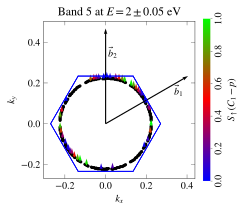

In [ ]:
ax1,ax2 = api.get_axes((3,3),ncols=2,widths=[20,1],hspace=0.1,wspace=0.1)

df2.poscar.set_bz(primitive = False)
df2.splot('kx','ky','eu',s=5,ax=ax1,color='k')
df2.splot('kx','ky','eu','su_1',arrows=['','su_1','su_1'],every=6,quiver_kws= dict(cmap='brg',scale=20),ax=ax1)
df2.colorbar(ax2)
df2.poscar.splot_bz(plane='xy',ax=ax1)
ax1.set_title('Band 5 at $E = 2 \pm 0.05$ eV')
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('$S_\\uparrow(C_1-p)$')

Text(0.5, 0.92, '$S_\\uparrow (C_1-p)$ colored by $E_\\uparrow$ of Band 5')

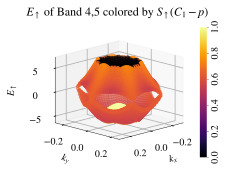

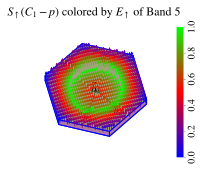

In [ ]:
df1['kz'] = 0
ax = df1.splot3d('kx','ky','eu','su_1',s=10,cmap='inferno')
df1.colorbar()
df3 = df1[df1['band'] == 5]
ax1 = df3.splot3d('kx','ky','kz',arrows=['','','su_1','eu'],norm=0.1,every=2,quiver_kws= dict(mutation_scale=5,arrowstyle='-|>',cmap='brg',zorder=3))
df3.poscar.splot_bz(ax=ax1).set_axis_off()
df3.colorbar()
ax.set(xlabel='$k_x $',ylabel='$k_y$',zlabel='$E_\\uparrow$')
ax1.view_init(elev=60,azim=45)
ax.set_title('$E_\\uparrow$ of Band 4,5 colored by $S_\\uparrow (C_1-p)$')
ax1.set_title('$S_\\uparrow (C_1-p)$ colored by $E_\\uparrow$ of Band 5')

## Plotting with any Library/Langauge
- You can plot using methods of your choices from your favorite libraries, to collect data for that purpose, see example below.
- You can use `df.get_data().to_json('file.json')` to save current data and open that in any other language of your choice.

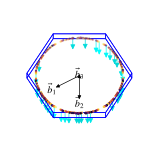

In [ ]:
ax3d = api.get_axes(axes_3d=True)
data = df2.get_data().band_5
KPTS = np.array([data.kx,data.ky,data.kz]).T
KPTS[:,2] = 0
ax3d.scatter(data.kx,data.ky,data.kz,c = data.eu,s=2,cmap='inferno')
df2.poscar.splot_bz(ax=ax3d,fill=False)

UVW = np.array([data.su_0, data.sd_1, data.su_1]).T
api.fancy_quiver3d(*KPTS[::8].T,*UVW[::8].T/5,C = np.abs(UVW)[::8]/UVW.max(),arrowstyle='-|>',ax=ax3d)
ax3d.set_axis_off()
ax3d.view_init(elev=60,azim=90)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_scatter3d(x = KPTS[:,0],y = KPTS[:,1], z = KPTS[:,2],marker =dict(color= np.abs(UVW)/UVW.max(),size=2),mode='markers')
df2.poscar.iplot_bz(fig=fig)
fig.add_cone(x = KPTS[::8,0],y = KPTS[::8,1], z = KPTS[::8,2],u = UVW[::8,0],v = UVW[::8,1], w = UVW[::8,2],sizemode='absolute',sizeref=50,colorscale='magma',showscale=False)
api.iplot2html(fig, modebar= False)

## Under Development

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as mtri


# Creating dataset
data = df1.get_data().band_4
x = data.kx
y = data.ky
z = data.eu
tri = mtri.Triangulation(x, y)

new_x = tri.x[tri.triangles].mean(axis=1)
new_y = tri.y[tri.triangles].mean(axis=1)

new_color = griddata((x,y),data.su_1,(new_x,new_y),method='linear')
new_color = np.abs((new_color - new_color.min())/np.ptp(new_color))

verts = np.array([tri.x[tri.triangles],tri.y[tri.triangles],z[tri.triangles]]).transpose([1,2,0])


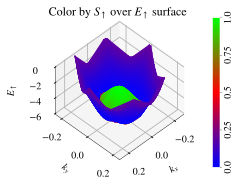

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pivotpy as pp

col = Poly3DCollection(verts,color=plt.get_cmap('brg')(new_color))
ax = pp.get_axes(axes_3d=True)
ax.add_collection3d(col)
ax.autoscale()
#df1.poscar.splot_bz(ax=ax,fill=False)
ax.set(zlim=(-6,0),xlim=(-0.27,0.27),ylim=(-0.24,0.24),
       zlabel='$E_\\uparrow$',xlabel='$k_x$',ylabel='$k_y$',
       title='Color by $S_\\uparrow$ over $E_\\uparrow$ surface')
ax.view_init(elev=45,azim=45)
cax = ax.get_figure().add_axes([0.9,0.1,0.03,0.8])
pp.add_colorbar(ax,cax,'brg',ticks=np.linspace(data.su_1.min(),data.su_1.max(),5))

In [ ]:
df1.get_data().to_json('../FermiData.json')